In [45]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
#import sympy
#import functools 
#from datetime import timedelta
#import wordninja as wrd
from pandas.tseries.frequencies import to_offset
from pandas.tseries.offsets import DateOffset
from sympy.stats import Normal, cdf
from scipy import stats

In [46]:
FWD_Price = pd.read_csv('PricesFile1.csv')

int_rate = pd.read_csv('InterestRates.csv')

NG_impvol_2020 = pd.read_csv('NG_ImpliedVols 2020.csv')
NG_impvol_2021 = pd.read_csv('NG_ImpliedVols 2021.csv')
NG_impvol_2022 = pd.read_csv('NG_ImpliedVols 2022.csv')

NG_price = FWD_Price.loc[FWD_Price.priceindex == "NYMEX Natural Gas"].drop(['priceindex'],axis=1)
NG_price = NG_price.loc[(NG_price.pricedate < NG_price.delivdate)]
#NG_price = NG_price.loc[FWD_Price.price < 0]

NG_price.pricedate = pd.to_datetime(NG_price.pricedate, format='%Y-%m-%d')
NG_price.delivdate = pd.to_datetime(NG_price.delivdate, format='%Y-%m-%d')


int_rate.pricedate = pd.to_datetime(int_rate.pricedate, format='%Y-%m-%d')

for i in range(len(int_rate.pricedate)):
    p_time = int_rate.pricedate[i]
    m_time = int_rate.maturity[i]
    maturedate  = p_time + to_offset(m_time)
    int_rate.maturity[i] = maturedate

int_rate.maturity =  pd.to_datetime(int_rate.maturity, format='%Y-%m-%d %H:%M:%s')  
int_rate = int_rate.loc[int_rate.maturity < "2022-12-31"]

delv_date = int_rate.maturity - pd.offsets.MonthBegin(1, normalize=True)
int_rate = int_rate.assign(delivdate = delv_date)

vol_frame = [NG_impvol_2020 , NG_impvol_2021 , NG_impvol_2022]
NG_vols = pd.concat(vol_frame , join ='inner').drop(['volatilityindex'],axis=1)
NG_vols.volatilitydate = pd.to_datetime(NG_vols.volatilitydate)
NG_vols.begtime = pd.to_datetime(NG_vols.begtime)
NG_vols = NG_vols.rename(columns={"volatilitydate":"t","begtime":"Tf","strikeprice":"K","volatility":"sigma"})

NG_pri_int = pd.merge(NG_price, int_rate, how= 'inner', on = ['pricedate','delivdate'])
NG_pri_int = NG_pri_int.rename(columns={"pricedate":"t","delivdate":"Tf", "price":"F", "bidrate":"r"})

NG_df = NG_vols.merge(NG_pri_int , how='inner' , on =['t','Tf'], sort = True)

Te = NG_df.Tf - DateOffset(days=1)
NG_df = NG_df.assign(Te = Te)

#NG_df = NG_df.loc[NG_df.Tf > NG_df.Te]
NG_df = NG_df.reset_index(drop=True)

#NG_df = NG_df.groupby(['t','Tf','F','r'])['sigma','K'].mean()
#NG_df = NG_df.get_group(['F'])
display(NG_df)

<ipython-input-46-6e51dc613690>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_rate.maturity[i] = maturedate


,t,K,Tf,sigma,F,maturity,r,Te
0,2020-03-02,1.03,2020-04-01,0.592,1.755,2020-04-30,0.995003,2020-03-31
1,2020-03-02,1.08,2020-04-01,0.576,1.755,2020-04-30,0.995003,2020-03-31
2,2020-03-02,1.13,2020-04-01,0.562,1.755,2020-04-30,0.995003,2020-03-31
3,2020-03-02,1.18,2020-04-01,0.548,1.755,2020-04-30,0.995003,2020-03-31
4,2020-03-02,1.23,2020-04-01,0.535,1.755,2020-04-30,0.995003,2020-03-31
...,...,...,...,...,...,...,...,...
147403,2020-05-29,4.80,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31
147404,2020-05-29,4.85,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31
147405,2020-05-29,4.90,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31
147406,2020-05-29,4.95,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31


In [47]:
t = pd.to_datetime('2020-03-02', format = '%Y-%m-%d')
NG_df1 = NG_df.loc[NG_df.t == t]
NG_df1 = NG_df.groupby(['Tf','Te','r'],as_index=False).mean()
NG_df1

,Tf,Te,r,K,sigma,F
0,2020-04-01,2020-03-31,0.459999,2.525000,0.679210,1.87700
1,2020-04-01,2020-03-31,0.495003,2.118333,0.578937,1.77700
2,2020-04-01,2020-03-31,0.500000,2.989387,1.020264,1.82708
3,2020-04-01,2020-03-31,0.514999,3.000000,0.785679,1.93500
4,2020-04-01,2020-03-31,0.595001,3.002469,1.293383,1.72800
...,...,...,...,...,...,...
1566,2022-11-01,2022-10-31,0.820000,3.053375,0.183725,2.41300
1567,2022-11-01,2022-10-31,0.845001,3.053375,0.174762,2.41300
1568,2022-11-01,2022-10-31,0.849998,3.053375,0.193212,2.34700
1569,2022-11-01,2022-10-31,0.879997,3.053375,0.198675,2.35300


In [82]:
def LSR (NG_df1):
    
    

    S_x = sum(NG_df1.F) - NG_df1.F.iloc[- 1]
    S_y = sum(NG_df1.F) - NG_df1.F.iloc[0]
    S_xx = sum((NG_df1.F)**2) - ((NG_df1.F.iloc[- 1])**2)
    S_yy = sum((NG_df1.F)**2) - ((NG_df1.F.iloc[0])**2)
    S_xy = 0
    for i in range(1,len(NG_df1.F)):
        S_xy = S_xy + NG_df1.F.iloc[i-1] * NG_df1.F.iloc[i]
        

    n = len(NG_df1.F)

    a = (n*S_xy - S_x*S_y) / (n*S_xx - S_x**2)
    b = (S_y - a*S_x) / n
    sd = np.sqrt((n*S_yy - S_y**2 - a*(n*S_xy - S_x*S_y)) / (n*(n-2)))

    delta = 0.15

    lmbd = -((np.log(a)) / delta)
    mu = b / (1-a)
    sigm = sd* np.sqrt((-2*np.log(a)) / (delta*(1-a**2)))

    S = np.zeros(n)
    T = np.zeros(n)

    S[0] = NG_df1.F.iloc[0]
    T[0] = 0
    mpr = NG_df1.r.iloc[0]

    for i in range(1, len(S)):
        lmbd_star = lmbd + mpr*sigm
        mu_star = (lmbd*mu) / (lmbd + mpr*sigm)
        #diffu = sigm * np.sqrt((1-np.exp(-2*lmbd*delta))/(2*lmbd)) * np.random.rand()
        #S[i] = (S[i-1] * np.exp(-lmbd*delta)) + (mu * (1-np.exp(-lmbd*delta))) + diffu
        diffu = sigm * S[i-1] * np.sqrt((1-np.exp(-2*lmbd_star*delta))/(2*lmbd_star)) * np.random.rand()
        S[i] = S[i-1] * np.exp(-lmbd_star*delta) + mu_star * (1-np.exp(-lmbd_star*delta)) + diffu
        T[i] = T[i-1] + delta
        #mpr = (((np.log(S[i])/S[i]) - (NG_df1.r.iloc[i]/100)) / sigm)
        mpr = (((S[i]-S[i-1])/S[i-1])-(NG_df1.r.iloc[i]/100)) / sigm
    
    
    return S, T

array([0.79892143, 1.2783687 , 1.33311659, 1.05160331, 0.1956663 ,
       1.81582415, 1.15943866, 1.15444681, 1.17661717, 1.29841392,
       0.09093671, 1.04750649, 1.00554522, 0.90632912, 1.24768413,
       1.39160711, 0.98576997, 1.50412623, 1.24613552, 1.19280529,
       0.58087269, 1.01386367, 1.47230637, 1.12008844, 1.14937766,
       0.99646751, 0.90432799, 0.92592081, 1.13491295, 1.37106455,
       1.19053722, 1.46051496, 0.        , 1.12149561, 0.93877529,
       1.29215309, 1.02169556, 1.63434627, 1.20764723, 1.23948191,
       1.23901581, 0.46251707, 1.01208057, 1.2346395 , 1.24497295,
       0.12424827, 0.        , 1.7298539 , 1.38034822, 0.17113541])

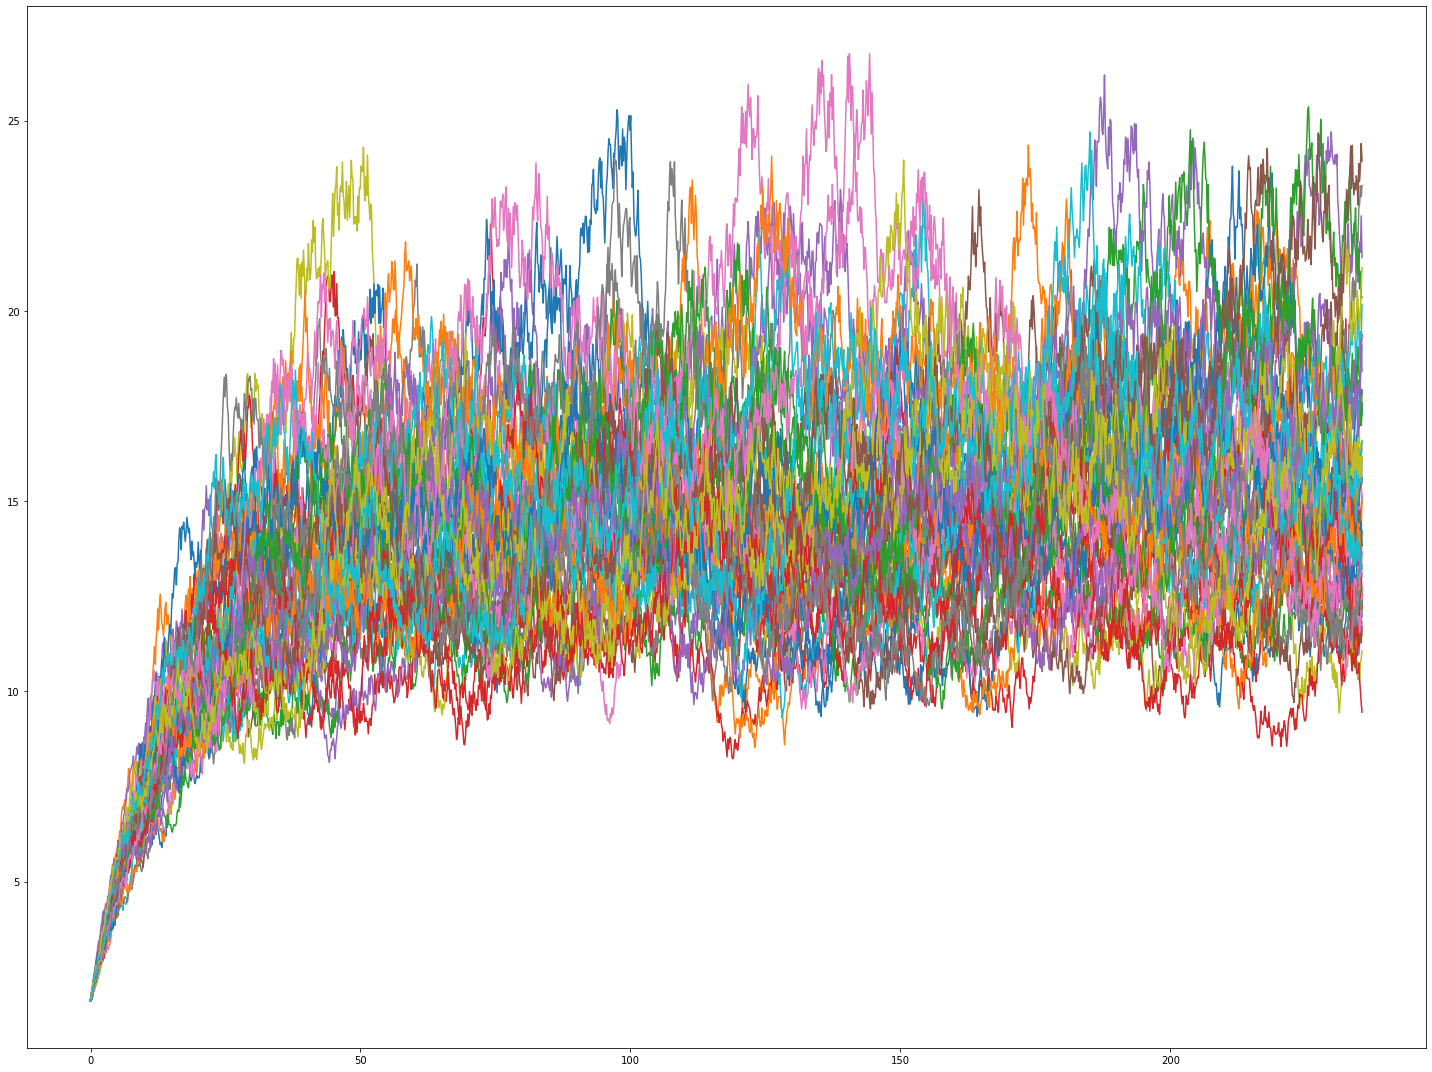

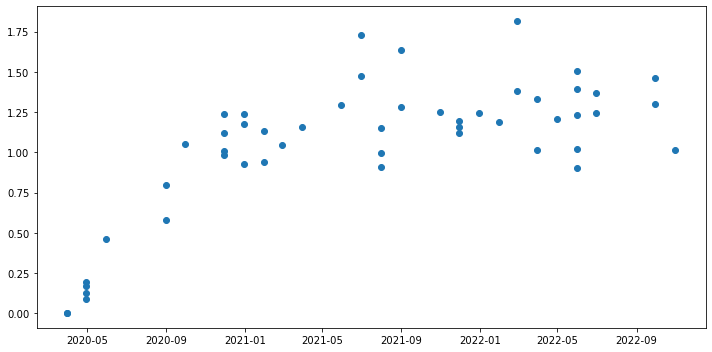

In [85]:
#time = ['2020-03-02','2020-04-15', '2020-05-01', '2020-05-29']

t = pd.to_datetime('2020-03-02', format = '%Y-%m-%d')
NG_df1 = NG_df.loc[NG_df.t == t]
NG_df1 = NG_df.groupby(['Tf','Te','r'],as_index=False).mean()

S = LSR(NG_df1)
#display(S)  
trial = 50

R = np.random.randint(0,len(NG_df1.F),trial)
call = np.zeros(trial)
t_call = np.empty((trial,), dtype='datetime64[us]') 


fig = plt.figure(figsize=(20,15), tight_layout=True)
#grid = fig.add_gridspec(2,2)

for i in range(len(R)):
    r = R[i]
    payoff = 0

    delta_t = NG_df.Te.iloc[r] - t
    time_diff = (delta_t.days)/365
    K = NG_df1.K.iloc[r]

    

    F , T = LSR(NG_df1)
    plt.plot(T, F , markersize=12)
    payoff = payoff + max(F[r]-K , 0)
    
    call[i] = np.exp(- (NG_df1.r.iloc[r]/100) * time_diff) * (payoff/10)   
    t_call[i] = NG_df1.Te.iloc[r]

fig = plt.figure(figsize=(10,5), tight_layout=True)
plt.scatter(t_call, call)
call